### Imports

In [1]:
import os
import csv
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sc

from gpolnel.utils.datasets import load_boston
from torch.utils.data import TensorDataset, DataLoader
# from gpolnel.utils.utils import mse, mae, rmse

from gpolnel.problems.inductive_programming import SML
# from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.inductive_programming import function_map
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm
from gpolnel.operators.initializers import grow, prm_grow, ERC, rhh, full, prm_full
from gpolnel.operators.variators import swap_xo, prm_subtree_mtn, prm_gs_xo, prm_gs_mtn, prm_point_mtn, prm_efficient_gs_xo, prm_efficient_gs_mtn
from gpolnel.operators.selectors import prm_tournament, roulette_wheel, double_tournament
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [2]:
X = pd.read_csv('datamart/data_project_nel.csv')
y = pd.read_csv('datamart/y_lactose.csv')
y

,lactose_percent
0,4.953503
1,4.983128
2,4.889104
3,4.868969
4,4.845402
...,...
319,4.891620
320,4.800946
321,4.916133
322,5.024776


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lactation                 324 non-null    int64  
 1   delivery_age_years        324 non-null    float64
 2   dim                       324 non-null    int64  
 3   dry_days                  177 non-null    float64
 4   forage_kg_day             324 non-null    float64
 5   rumination_min_day        324 non-null    float64
 6   milk_kg_day               324 non-null    float64
 7   milk_kg_min_robot         324 non-null    float64
 8   milkings_day              324 non-null    float64
 9   errors_by_100_milkings    324 non-null    float64
 10  high_cdt_by_100_milkings  324 non-null    float64
 11  watery_by_100_milkings    324 non-null    float64
 12  refusals_by_milking       324 non-null    float64
 13  colostrum_separated_kg    324 non-null    float64
dtypes: float64

Since dataset is quite small (only has 324 rows) and dry_days feature has 147 missing values that cannot be filled using any logic, as cow did not have any dry days, we will drop this feature not to lose observations.

In [4]:
X = X[X.columns.drop('dry_days')]

### Data exploration and preprocessing

Since we should rely only train data while doing the preprocessing we will split data into train, val and test. After it we will do data exploration and preprocessing

In [5]:
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=2)

print('Train:\t{}\nVal:\t{}\nTest:\t{}'.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))
print('Total:\t{}'.format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]))


Train:	158
Val:	68
Test:	98
Total:	324


In [6]:
X_train

,lactation,delivery_age_years,dim,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
133,2,2.833333,334,4.110359,560.005970,37.492814,4.807242,2.140719,0.279720,0.000000,0.000000,0.018182,0.0
221,1,1.833333,310,4.900871,453.147910,34.244839,2.474946,3.016129,0.000000,0.000000,0.000000,0.349733,0.0
55,2,3.666667,284,4.582817,574.582456,41.941901,2.902560,2.200704,0.640000,0.000000,0.000000,0.041600,43.7
22,5,6.000000,308,4.493409,521.967638,39.289935,3.838451,2.503247,0.000000,0.000000,0.000000,0.063554,0.0
281,1,1.750000,318,4.446509,550.905956,30.713836,1.647146,2.830189,10.888889,0.666667,0.555556,0.286667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,3,4.000000,287,4.579129,564.170139,46.569686,1.770747,2.181185,0.319489,0.000000,0.000000,0.070288,0.0
69,2,2.833333,280,4.463857,426.355872,35.073571,3.932714,2.889286,1.236094,0.000000,0.000000,0.365884,6.4
48,4,4.916667,369,4.525691,611.240541,48.278591,4.267227,2.246612,1.206273,0.000000,0.000000,0.009650,25.9
215,1,1.750000,400,4.687075,499.384040,34.305500,2.390338,2.675000,1.214953,0.000000,0.000000,0.291589,0.0


In [7]:
y_train

,lactose_percent
133,4.874195
221,4.826024
55,4.810900
22,4.827283
281,4.896059
...,...
93,4.794831
69,5.007344
48,4.866383
215,4.994884


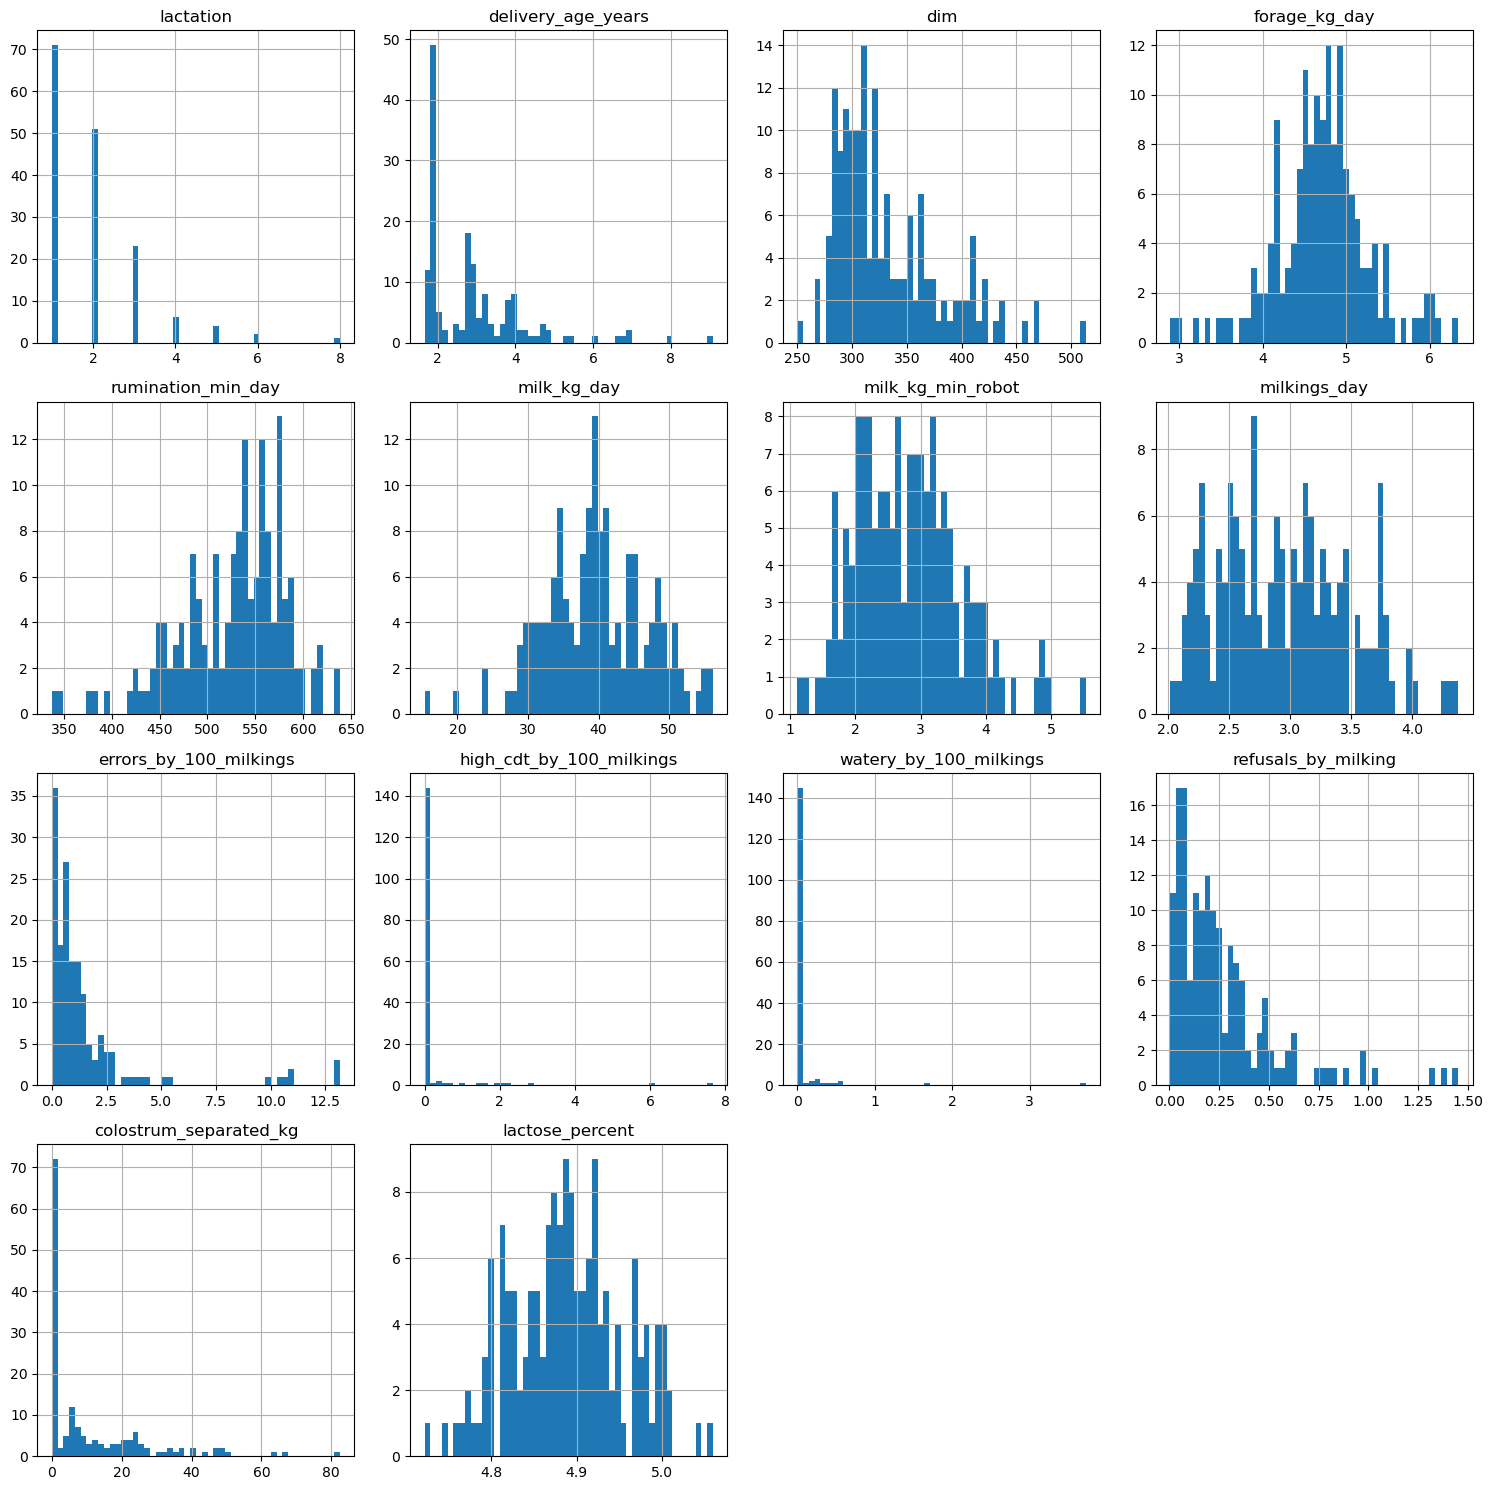

In [8]:
pd.concat([X_train, y_train], axis = 1).hist(figsize=(15, 15), bins=50)
plt.grid(False)
plt.tight_layout()
plt.show()

Our data has outliers and a lot of skewness as we see from distributions. For GP algorithms it is not that crucial to fix it as there are no statistical assumptions such as we have with Linear models. However, it might still help to improve the perfomance. Moreover, we will use simple Neaural Networks, for which it is important and might affect the results. That is why we will fix it later

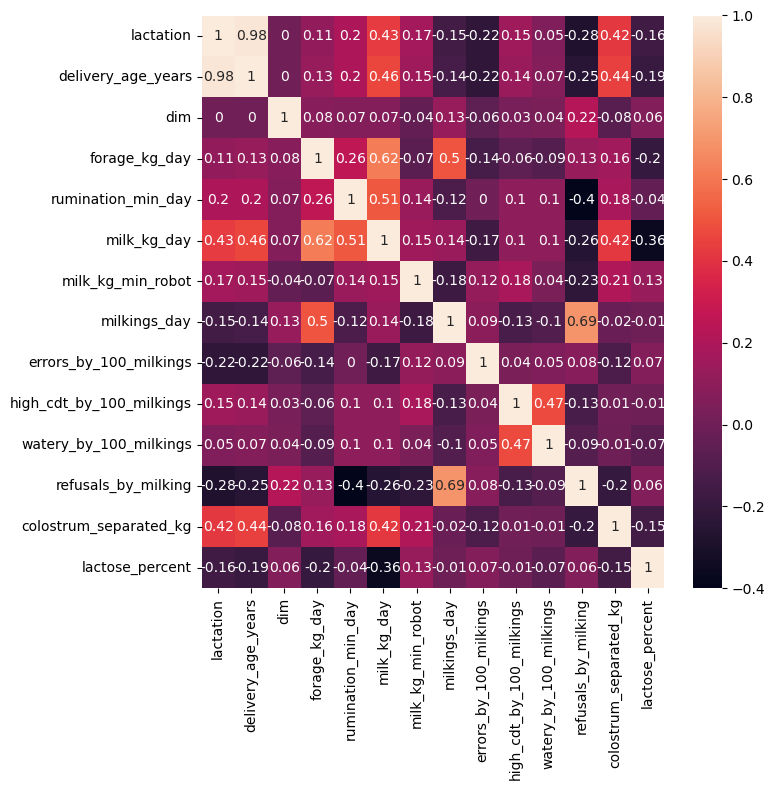

In [9]:
plt.figure(figsize=(8,8))
sns.heatmap(np.round(pd.concat([X_train, y_train], axis = 1).corr(),2), annot=True)
plt.grid(False)
plt.tight_layout()
plt.show()

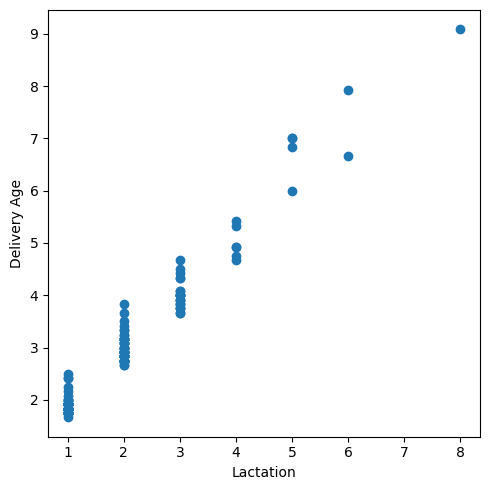

In [10]:
#Explore lactation and delivery_age_years

plt.figure(figsize=(5,5))
plt.scatter(X_train['lactation'], X_train['delivery_age_years'])
plt.xlabel('Lactation')
plt.ylabel('Delivery Age')
plt.grid(False)
plt.tight_layout()
plt.show()

- From the heatmap we see that lactation and delivery_age_years are almost perfectly correleted meaning that we can use one of them. We will remove lactation as it has less variability comapring to delivery_age_years
- There are no other strong correlations in our data
- Strongest correlation with target is -0.36 (still quite small number) for milk_kg_day, meaning that in our data the more milk is produced by cow per day the lower is lactose level. 

In [11]:
X_train = X_train[X_train.columns.drop('lactation')]
X_val = X_val[X_val.columns.drop('lactation')]
X_test = X_test[X_test.columns.drop('lactation')]

In [12]:
# Exploring skewness and possible tranformations

for k in range(len(X_train.columns)):
    i = X_train.columns[k]
    print(i)
    print("Skewness: {}".format(sc.skew(X_train[i])))
    if sc.skew(X_train[i]) > 0:
        print("Skewness after log transform: {}".format(sc.skew(np.log1p(X_train[i]))))
        print("Skewness after sqrt transform: {}".format(sc.skew(np.sqrt(X_train[i]))))
    else:
        print("Skewness after squared transform: {}".format(sc.skew(X_train[i]**2)))
    print('\n')
    # plt.figure(figsize=(5, 3))
    # sns.histplot(X_train[i]**0.5, bins=30, kde=True)
    plt.show()

delivery_age_years
Skewness: 1.8555628204971886
Skewness after log transform: 0.9487813578053107
Skewness after sqrt transform: 1.2339191927804463


dim
Skewness: 1.1497411518162417
Skewness after log transform: 0.8406213090263617
Skewness after sqrt transform: 0.9903879618967192


forage_kg_day
Skewness: -0.11249927380758144
Skewness after squared transform: 0.4443410102604845


rumination_min_day
Skewness: -0.8095271495341474
Skewness after squared transform: -0.4813787342609805


milk_kg_day
Skewness: -0.1185513458848651
Skewness after squared transform: 0.43178359988284065


milk_kg_min_robot
Skewness: 0.5790859857488777
Skewness after log transform: 0.011650894262377344
Skewness after sqrt transform: 0.18694774184472793


milkings_day
Skewness: 0.36215227912122955
Skewness after log transform: 0.11993954708911854
Skewness after sqrt transform: 0.19870578739705722


errors_by_100_milkings
Skewness: 3.2534975281841434
Skewness after log transform: 1.3101412055960173
Skewness after s

We will apply following transformations to fix positive and negative skewness:

Sqrt
- errors_by_100_milkings
- high_cdt_by_100_milkings
- watery_by_100_milkings
- refusals_by_milking

Log
- delivery_age_years
- dim
- milk_kg_min_robot
- colostrum_separated_kg

Square
- rumination_min_day

In [13]:
for i in ['errors_by_100_milkings', 'high_cdt_by_100_milkings', 'watery_by_100_milkings', 'refusals_by_milking']:
    X_train[i] = np.sqrt(X_train[i])
    X_val[i] = np.sqrt(X_val[i])
    X_test[i] = np.sqrt(X_test[i])

for i in ['delivery_age_years', 'dim', 'milk_kg_min_robot', 'colostrum_separated_kg']:
    X_train[i] = np.log1p(X_train[i])
    X_val[i] = np.log1p(X_val[i])
    X_test[i] = np.log1p(X_test[i])

for i in ['rumination_min_day']:
    X_train[i] = X_train[i]**2
    X_val[i] = X_val[i]**2
    X_test[i] = X_test[i]**2



/var/folders/kk/jn6jnrpj6_30s05tyyfmmk9h0000gn/T/ipykernel_4933/2647383726.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i] = np.sqrt(X_train[i])
/var/folders/kk/jn6jnrpj6_30s05tyyfmmk9h0000gn/T/ipykernel_4933/2647383726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i] = np.log1p(X_train[i])
/var/folders/kk/jn6jnrpj6_30s05tyyfmmk9h0000gn/T/ipykernel_4933/2647383726.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

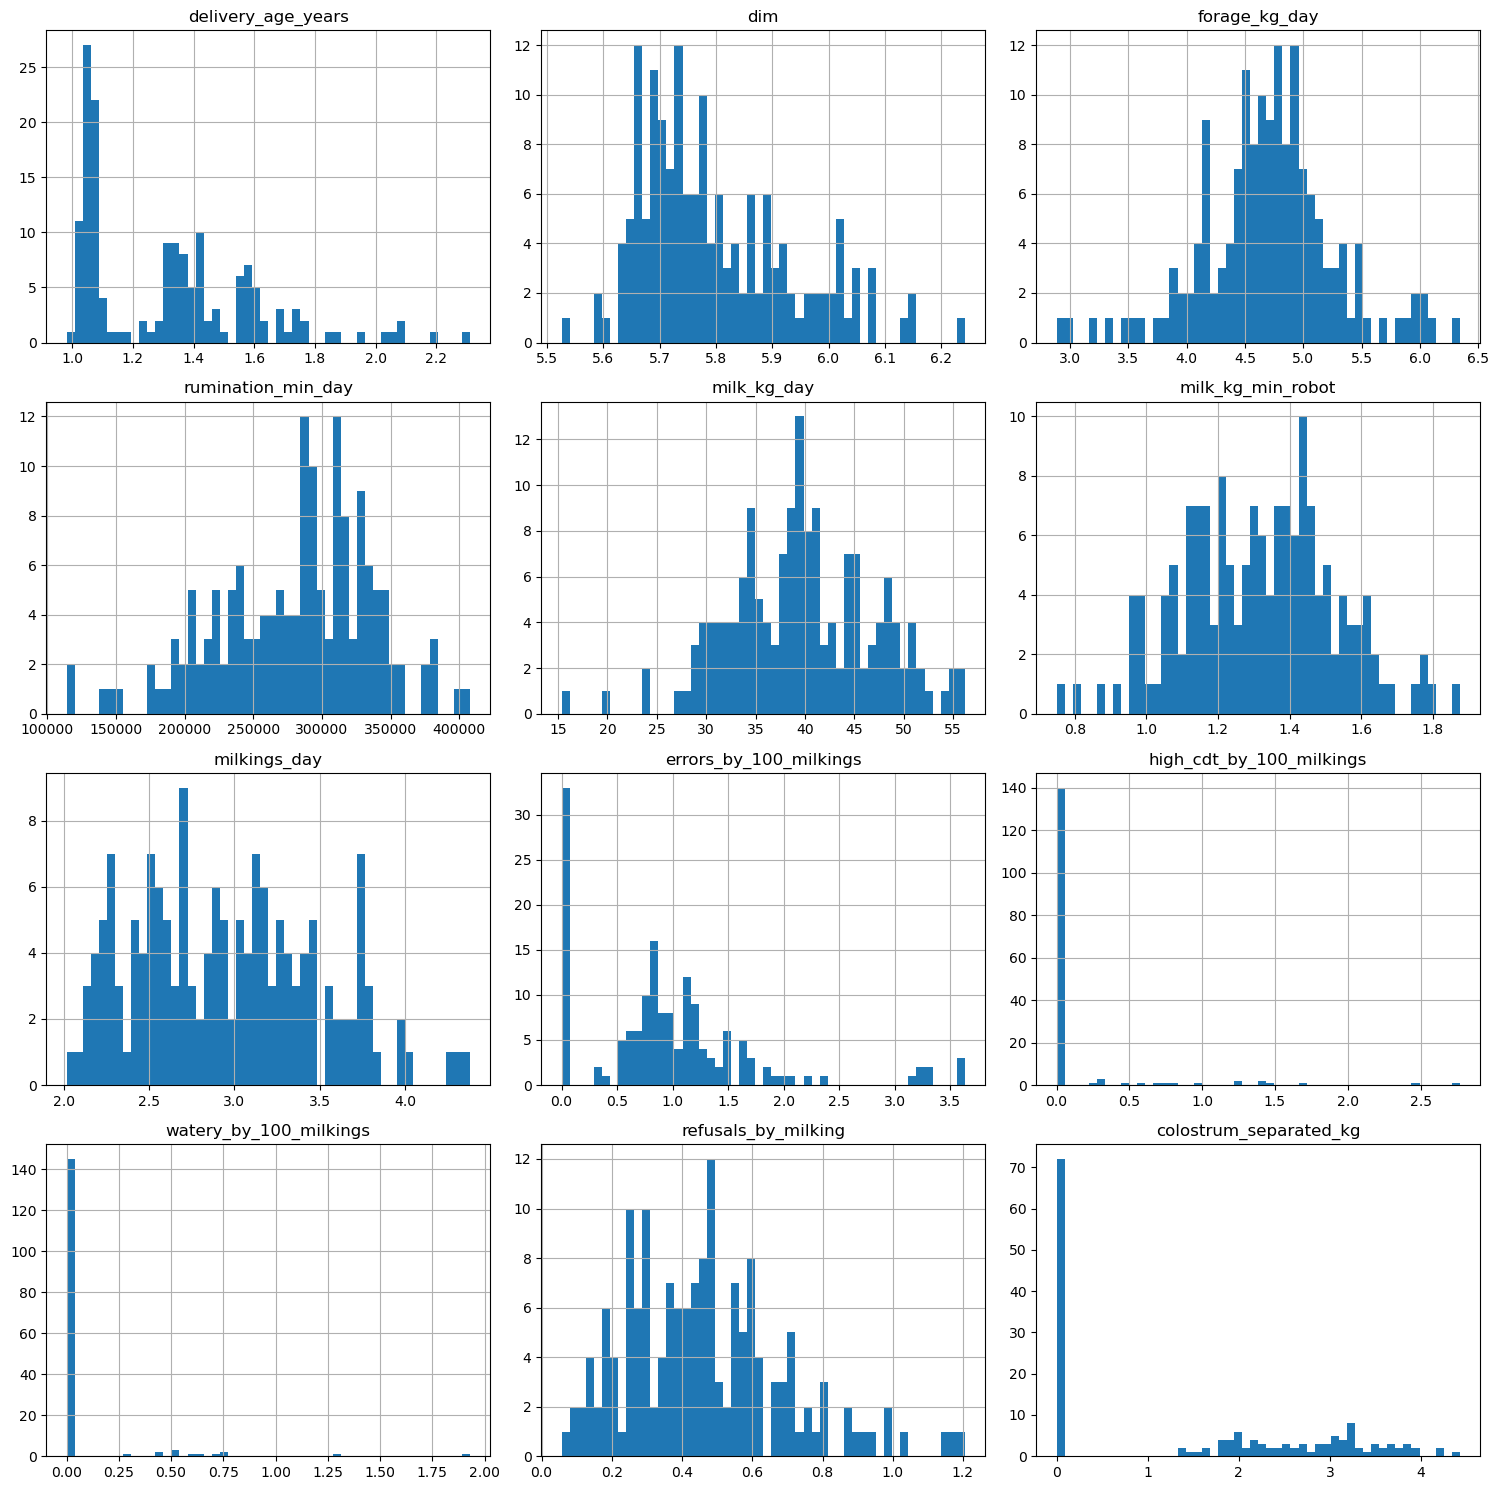

In [14]:
X_train.hist(figsize=(15, 15), bins=50)
plt.grid(False)
plt.tight_layout()
plt.show()

It looks less skewed now and we will try to identify outliers using visual approach, exploring distributions from plots. Replace them with NaN values in train, val, test and then use KNN Imputer fitted with train data to fill these misisng values

In [15]:
X_train.columns

Index(['delivery_age_years', 'dim', 'forage_kg_day', 'rumination_min_day',
       'milk_kg_day', 'milk_kg_min_robot', 'milkings_day',
       'errors_by_100_milkings', 'high_cdt_by_100_milkings',
       'watery_by_100_milkings', 'refusals_by_milking',
       'colostrum_separated_kg'],
      dtype='object')

In [16]:
X_train.loc[X_train['watery_by_100_milkings'] > 1, 'watery_by_100_milkings'] = np.nan
X_train.loc[X_train['high_cdt_by_100_milkings'] > 2, 'high_cdt_by_100_milkings'] = np.nan
X_train.loc[X_train['errors_by_100_milkings'] > 3, 'errors_by_100_milkings'] = np.nan
X_train.loc[X_train['colostrum_separated_kg'] > 4, 'colostrum_separated_kg'] = np.nan
X_train.loc[X_train['milkings_day'] > 4, 'milkings_day'] = np.nan
X_train.loc[X_train['refusals_by_milking'] > 1, 'refusals_by_milking'] = np.nan
X_train.loc[X_train['delivery_age_years'] > 1.8, 'delivery_age_years'] = np.nan
X_train.loc[X_train['dim'] > 6.1, 'dim'] = np.nan
X_train.loc[X_train['dim'] < 5.6, 'dim'] = np.nan
X_train.loc[X_train['forage_kg_day'] > 6, 'forage_kg_day'] = np.nan
X_train.loc[X_train['forage_kg_day'] < 3.5, 'forage_kg_day'] = np.nan
X_train.loc[X_train['rumination_min_day'] > 390000, 'rumination_min_day'] = np.nan
X_train.loc[X_train['rumination_min_day'] < 170000, 'rumination_min_day'] = np.nan
X_train.loc[X_train['milk_kg_day'] < 25, 'milk_kg_day'] = np.nan
X_train.loc[X_train['milk_kg_min_robot'] < 0.9, 'milk_kg_min_robot'] = np.nan
X_train.loc[X_train['milk_kg_min_robot'] > 1.7, 'milk_kg_min_robot'] = np.nan

X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, 133 to 86
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   delivery_age_years        149 non-null    float64
 1   dim                       151 non-null    float64
 2   forage_kg_day             149 non-null    float64
 3   rumination_min_day        151 non-null    float64
 4   milk_kg_day               154 non-null    float64
 5   milk_kg_min_robot         150 non-null    float64
 6   milkings_day              154 non-null    float64
 7   errors_by_100_milkings    150 non-null    float64
 8   high_cdt_by_100_milkings  156 non-null    float64
 9   watery_by_100_milkings    156 non-null    float64
 10  refusals_by_milking       154 non-null    float64
 11  colostrum_separated_kg    155 non-null    float64
dtypes: float64(12)
memory usage: 16.0 KB


In [17]:
X_val.loc[X_val['watery_by_100_milkings'] > 1, 'watery_by_100_milkings'] = np.nan
X_val.loc[X_val['high_cdt_by_100_milkings'] > 2, 'high_cdt_by_100_milkings'] = np.nan
X_val.loc[X_val['errors_by_100_milkings'] > 3, 'errors_by_100_milkings'] = np.nan
X_val.loc[X_val['colostrum_separated_kg'] > 4, 'colostrum_separated_kg'] = np.nan
X_val.loc[X_val['milkings_day'] > 4, 'milkings_day'] = np.nan
X_val.loc[X_val['refusals_by_milking'] > 1, 'refusals_by_milking'] = np.nan
X_val.loc[X_val['delivery_age_years'] > 1.8, 'delivery_age_years'] = np.nan
X_val.loc[X_val['dim'] > 6.1, 'dim'] = np.nan
X_val.loc[X_val['dim'] < 5.6, 'dim'] = np.nan
X_val.loc[X_val['forage_kg_day'] > 6, 'forage_kg_day'] = np.nan
X_val.loc[X_val['forage_kg_day'] < 3.5, 'forage_kg_day'] = np.nan
X_val.loc[X_val['rumination_min_day'] > 390000, 'rumination_min_day'] = np.nan
X_val.loc[X_val['rumination_min_day'] < 170000, 'rumination_min_day'] = np.nan
X_val.loc[X_val['milk_kg_day'] < 25, 'milk_kg_day'] = np.nan
X_val.loc[X_val['milk_kg_min_robot'] < 0.9, 'milk_kg_min_robot'] = np.nan
X_val.loc[X_val['milk_kg_min_robot'] > 1.7, 'milk_kg_min_robot'] = np.nan

X_test.loc[X_test['watery_by_100_milkings'] > 1, 'watery_by_100_milkings'] = np.nan
X_test.loc[X_test['high_cdt_by_100_milkings'] > 2, 'high_cdt_by_100_milkings'] = np.nan
X_test.loc[X_test['errors_by_100_milkings'] > 3, 'errors_by_100_milkings'] = np.nan
X_test.loc[X_test['colostrum_separated_kg'] > 4, 'colostrum_separated_kg'] = np.nan
X_test.loc[X_test['milkings_day'] > 4, 'milkings_day'] = np.nan
X_test.loc[X_test['refusals_by_milking'] > 1, 'refusals_by_milking'] = np.nan
X_test.loc[X_test['delivery_age_years'] > 1.8, 'delivery_age_years'] = np.nan
X_test.loc[X_test['dim'] > 6.1, 'dim'] = np.nan
X_test.loc[X_test['dim'] < 5.6, 'dim'] = np.nan
X_test.loc[X_test['forage_kg_day'] > 6, 'forage_kg_day'] = np.nan
X_test.loc[X_test['forage_kg_day'] < 3.5, 'forage_kg_day'] = np.nan
X_test.loc[X_test['rumination_min_day'] > 390000, 'rumination_min_day'] = np.nan
X_test.loc[X_test['rumination_min_day'] < 170000, 'rumination_min_day'] = np.nan
X_test.loc[X_test['milk_kg_day'] < 25, 'milk_kg_day'] = np.nan
X_test.loc[X_test['milk_kg_min_robot'] < 0.9, 'milk_kg_min_robot'] = np.nan
X_test.loc[X_test['milk_kg_min_robot'] > 1.7, 'milk_kg_min_robot'] = np.nan

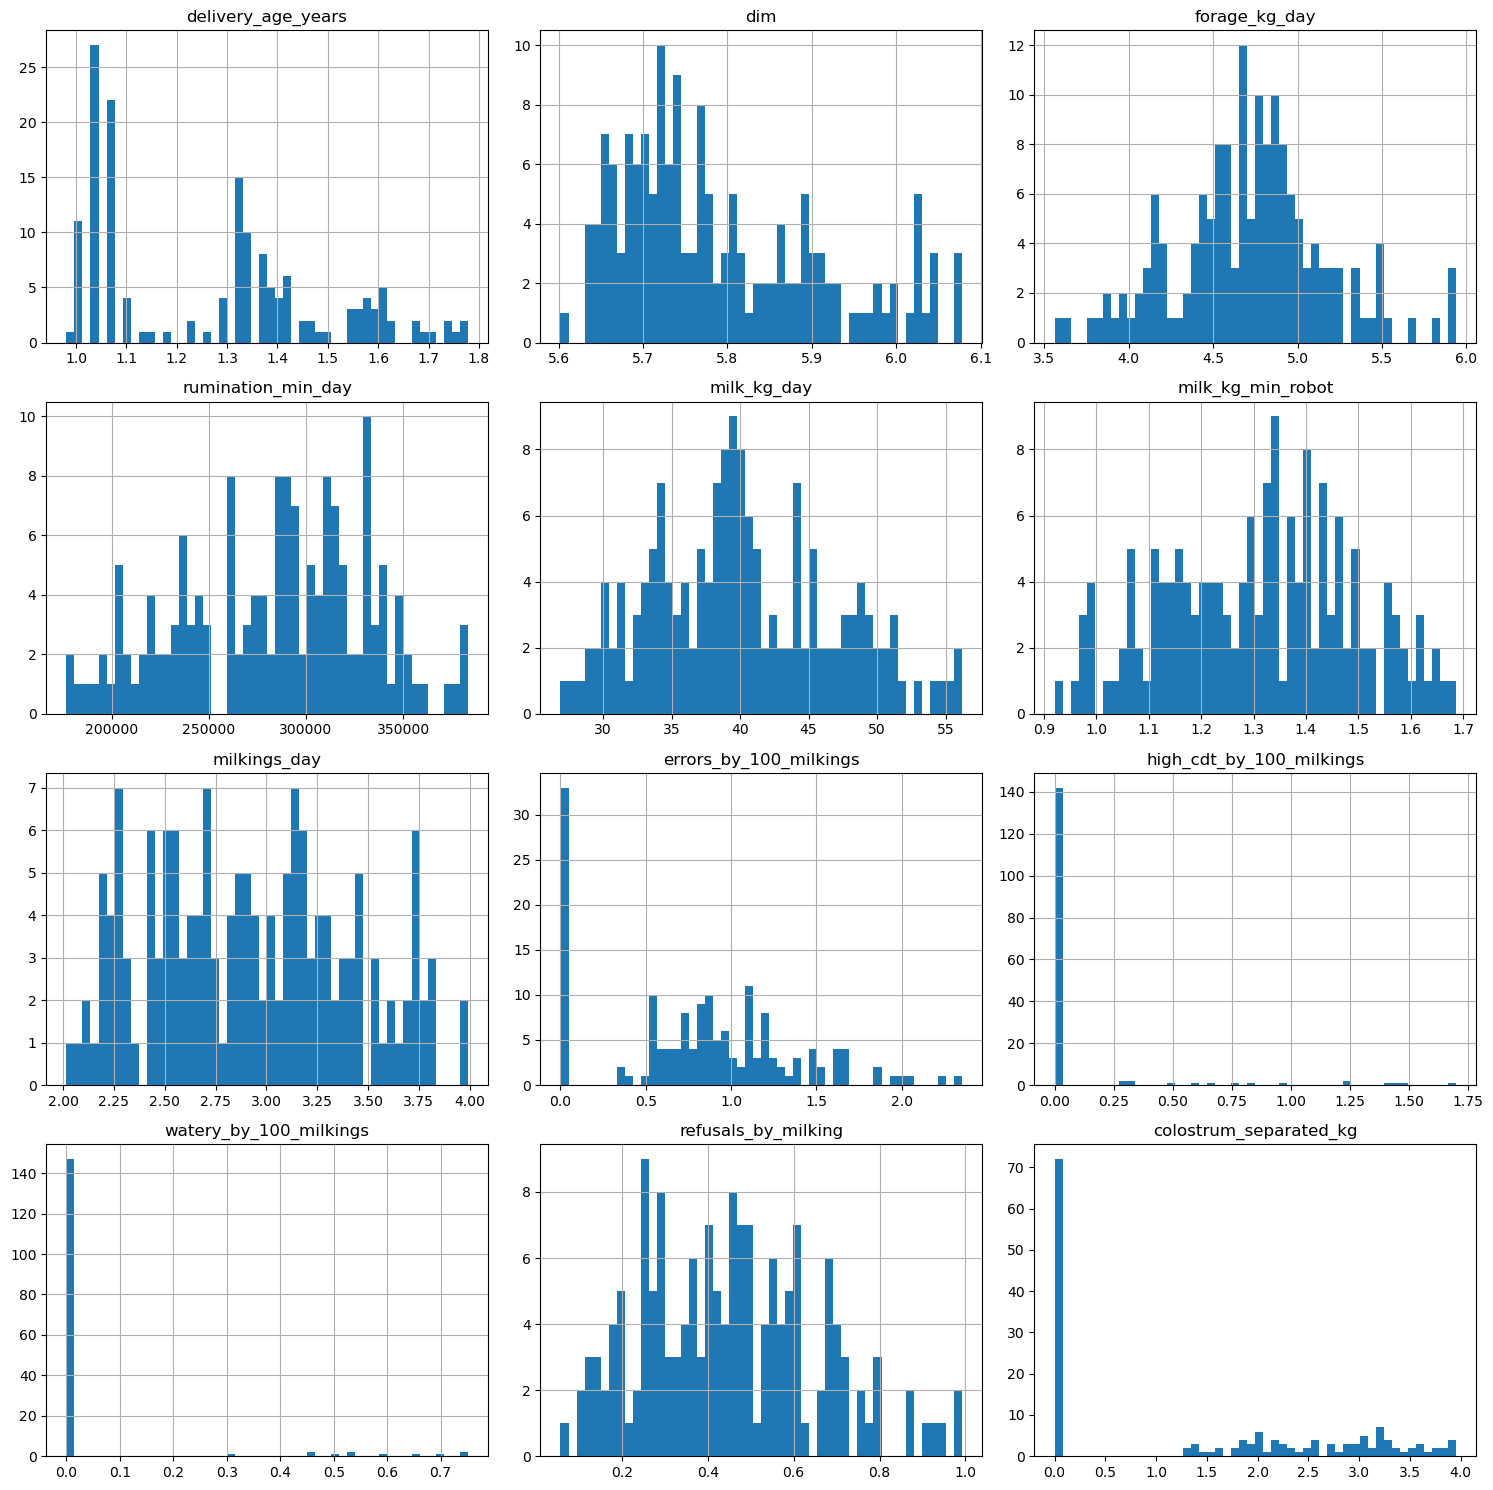

In [18]:
imputer = KNNImputer(n_neighbors=5)  

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_train.columns, index=X_val.index)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_train.columns, index=X_test.index)

X_train.hist(figsize=(15, 15), bins=50)
plt.grid(False)
plt.tight_layout()
plt.show()

In [19]:
X_train

,delivery_age_years,dim,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
133,1.343735,5.814131,4.110359,313606.686603,37.492814,1.336791,2.140719,0.528886,0.000000,0.000000,0.134840,0.000000
221,1.041454,5.739793,4.900871,205343.028308,34.244839,1.245579,3.016129,0.000000,0.000000,0.000000,0.591382,0.000000
55,1.540445,5.652489,4.582817,330144.998904,41.941901,1.361633,2.200704,0.800000,0.000000,0.000000,0.203961,3.799974
22,1.292482,5.733341,4.493409,272450.214640,39.289935,1.576595,2.503247,0.000000,0.000000,0.000000,0.252099,0.000000
281,1.011601,5.765191,4.446509,303497.372481,30.713836,0.973482,2.830189,0.563057,0.816497,0.745356,0.535413,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
93,1.609438,5.662960,4.579129,318287.945614,46.569686,1.019117,2.181185,0.565233,0.000000,0.000000,0.265118,0.000000
69,1.343735,5.638355,4.463857,181779.329492,35.073571,1.595889,2.889286,1.111798,0.000000,0.000000,0.604883,2.001480
48,1.777773,5.913503,4.525691,373614.998400,48.278591,1.661504,2.246612,1.098304,0.000000,0.000000,0.098235,3.292126
215,1.011601,5.993961,4.687075,249384.419307,34.305500,1.220930,2.675000,1.102249,0.000000,0.000000,0.539990,0.000000


In [20]:
y_train

,lactose_percent
133,4.874195
221,4.826024
55,4.810900
22,4.827283
281,4.896059
...,...
93,4.794831
69,5.007344
48,4.866383
215,4.994884


Final step is to scale all data

In [21]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

Before applying models we just need to convert data to tensors and create data loaders, since we wil work with Pytorch

In [22]:
#convert dataframes to tensors

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).reshape(1,-1)[0]
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(1,-1)[0]
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(1,-1)[0]

print(X_train.shape, y_train.shape)

torch.Size([158, 12]) torch.Size([158])


In [23]:
seed = 1
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
shuffle = True

In [24]:
total_batches = 1
batch_size = X_train.shape[0]
print('Batch size: {}\nTotal batches: {}\n'.format(batch_size, total_batches))

print('Train:\t{}\nVal:\t{}\nTest:\t{}'.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))
print('Total:\t{}'.format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]))

# Creates training and validatation data sets
ds_train = TensorDataset(X_train, y_train)
ds_val = TensorDataset(X_val, y_val)

# Creates training and test data loaders
dl_train = DataLoader(ds_train, batch_size, shuffle)
dl_val = DataLoader(ds_val, batch_size, shuffle)


Batch size: 158
Total batches: 1

Train:	158
Val:	68
Test:	98
Total:	324


### GP

In [35]:
fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

sspace_sml = {
    'n_dims': X_train.shape[1],
    'function_set': fset, 'constant_set': ERC(-1., 1.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'max_depth': 10, 
    'n_batches': total_batches,
    'device': device
}

pi_sml = SML(
    sspace=sspace_sml,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train, dl_test=dl_val,  # For the algorithm, the unseen is our validation!
    n_jobs=1
)

In [85]:
ps = 1000
selection_pressure = .07
mutation_prob = .1
xo_prob = .9
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=grow,
    selector=prm_tournament(pressure=selection_pressure),
    crossover=swap_xo,
    mutator=prm_subtree_mtn(initializer=prm_grow(sspace_sml)),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed
)


In [151]:
ps = 1000
selection_pressure = .007
mutation_prob = .1
xo_prob = .9
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=grow,
    selector=double_tournament(selection_pressure),
    crossover=swap_xo,
    mutator=prm_subtree_mtn(initializer=prm_grow(sspace_sml)),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed
)

In [152]:
mheuristic._initialize()

In [153]:
print(f'\nGP population: {mheuristic.pop.__class__} ({len(mheuristic.pop)} individuals)')

print(f'\nPoppulation fitness {mheuristic.pop.fit[:3]}...')
print(f'Poppulation valid {mheuristic.pop.valid[:3]}...\n')

for i in range(3):
    print(f'Individual {i}: {mheuristic.pop.individuals[i].repr_}, fitness {mheuristic.pop.individuals[i].fit}')

print(f'\nGP best individual {mheuristic.best_sol.printTree(out="string")}, fitness {mheuristic.best_sol.fit}\n\n')


GP population: <class 'gpolnel.utils.population.PopulationTree'> (1000 individuals)

Poppulation fitness tensor([1.2274, 0.5179, 0.5852], device='mps:0')...
Poppulation valid [True, True, True]...

Individual 0: [sub, mul, div, 6, tensor(-0.9433, device='mps:0'), 0, 3], fitness 1.2274309396743774
Individual 1: [add, add, 0, 6, sub, 8, 10], fitness 0.517891526222229
Individual 2: [sub, 6, sub, 5, 10], fitness 0.5852105021476746

GP best individual mul( x_5, 0.8645 ), fitness 0.26715728640556335




In [154]:
# # Log settings
# file_dir = './log/'
# file_name = 'intro.log'
# log_path = file_dir + file_name
# if os.path.exists(file_dir + file_name):
#     os.remove(file_dir + file_name)
# if not os.path.exists(file_dir):
#     os.makedirs(file_dir)

# Learning
n_iter = 50
mheuristic.solve(
    n_iter,
    verbose=3, 
    # log=3, log_path=log_path,
    test_elite=True
)

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 5        0.192588         0.201265              0.701 | -1                             -1


KeyboardInterrupt: 

In [89]:
for i in range(10):
    print(mheuristic.pop.individuals[i].repr_)

[sub, mul, tensor(-0.0393, device='mps:0'), sub, sub, sub, div, 4, 5, sub, tensor(-0.7847, device='mps:0'), tensor(-0.4221, device='mps:0'), sub, sub, mul, 3, 5, div, 8, 10, tensor(-0.5088, device='mps:0'), sub, sub, mul, tensor(-0.5088, device='mps:0'), div, sub, mul, 4, 4, mul, 7, 10, 0, sub, mul, 9, 5, mul, 3, 5, sub, mul, add, 11, mul, 4, 4, 4, mul, mul, tensor(-0.5088, device='mps:0'), div, mul, 4, 4, 1, sub, 10, div, 8, 10, tensor(-0.5088, device='mps:0')]
[sub, mul, tensor(-0.0393, device='mps:0'), sub, sub, sub, div, 4, 5, add, sub, tensor(0.8351, device='mps:0'), 11, div, 3, 8, sub, sub, sub, mul, 3, 5, div, 8, 10, tensor(-0.5088, device='mps:0'), tensor(-0.5088, device='mps:0'), sub, sub, mul, tensor(-0.5088, device='mps:0'), div, sub, mul, 4, 4, mul, 7, 10, 0, sub, mul, 9, 5, mul, mul, tensor(-0.5088, device='mps:0'), sub, 10, 7, sub, sub, 10, div, 8, 10, tensor(-0.5088, device='mps:0'), sub, mul, add, mul, add, 11, mul, 4, 4, 4, mul, mul, 6, 3, 10, 4, mul, mul, tensor(-0.50

In [90]:
mheuristic.best_sol.printTree()

sub( mul( -0.0393, sub( sub( sub( div( x_4, x_5 ) sub( sub( mul( x_6, x_3 ) add( x_8, x_0 ) ) -0.5088 ) ) sub( sub( sub( mul( x_3, x_5 ) div( x_8, x_10 ) ) -0.5088 ) -0.5088 ) ) sub( sub( mul( -0.5088, div( sub( mul( x_4, x_4 ) mul( x_7, x_10 ) ) x_0 ) ) sub( mul( x_9, x_5 ) mul( mul( -0.5088, sub( x_10, x_7 ) ) sub( sub( x_10, div( x_8, x_10 ) ) -0.5088 ) ) ) ) sub( mul( add( mul( add( x_11, mul( x_4, x_4 ) ) x_4 ) mul( mul( x_6, x_3 ) x_10 ) ) x_4 ) mul( mul( -0.5088, div( mul( x_4, x_4 ) x_1 ) ) sub( x_10, div( x_8, x_10 ) ) ) ) ) ) ) -0.5088 )


### GSGP

In [155]:
fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

sspace_sml_gs = {
    'n_dims': X_train.shape[1],
    'function_set': fset, 'constant_set': ERC(-1., 1.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'device': device,
    'n_batches': 1
}

pi_sml = SML(
    sspace=sspace_sml_gs,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train, dl_test=dl_val
)

In [156]:
to, by = 5.0, 0.25
ms = torch.arange(by, to + by, by, device=device)

print(ms)

tensor([0.2500, 0.5000, 0.7500, 1.0000, 1.2500, 1.5000, 1.7500, 2.0000, 2.2500,
        2.5000, 2.7500, 3.0000, 3.2500, 3.5000, 3.7500, 4.0000, 4.2500, 4.5000,
        4.7500, 5.0000], device='mps:0')


In [157]:
ps = 1000
selection_pressure = .07
mutation_prob = .1
xo_prob = .9
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=grow,
    selector=prm_tournament(pressure=selection_pressure),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed,
    #
    # Notice that, in GPOL-based implementation that we are using, 
    # these operators are the only settings that 
    # are necessary to define a Geometric Semantic GP.
    #
    crossover=prm_gs_xo(prm_grow(sspace=pi_sml.sspace), device=device),
    mutator=prm_gs_mtn(prm_grow(sspace=pi_sml.sspace), ms)
)

In [158]:
mheuristic._initialize()

In [159]:
print(mheuristic.pop)

0)	[sub, mul, div, 6, tensor(-0.9433, device='mps:0'), 0, 3] (fit: tensor(1.2274, device='mps:0'))
1)	[add, add, 0, 6, sub, 8, 10] (fit: tensor(0.5179, device='mps:0'))
2)	[sub, 6, sub, 5, 10] (fit: tensor(0.5852, device='mps:0'))
3)	[sub, 7, 0] (fit: tensor(0.6571, device='mps:0'))
4)	[div, 2, 11] (fit: tensor(0.5264, device='mps:0'))
5)	[mul, 1, 6] (fit: tensor(0.4010, device='mps:0'))
6)	[mul, div, 9, 2, add, 8, 5] (fit: tensor(0.6942, device='mps:0'))
7)	[mul, 9, div, 8, 0] (fit: tensor(1.4130, device='mps:0'))
8)	[div, div, 6, tensor(0.0802, device='mps:0'), 0] (fit: tensor(63.8547, device='mps:0'))
9)	[sub, sub, mul, 10, tensor(-0.9666, device='mps:0'), mul, 9, 1, sub, 2, 4] (fit: tensor(1.0607, device='mps:0'))
10)	[div, 1, mul, 3, 11] (fit: tensor(2.0927, device='mps:0'))
11)	[sub, 0, add, 11, div, 3, 10] (fit: tensor(3.9228, device='mps:0'))
12)	[add, 6, mul, 0, tensor(-0.8471, device='mps:0')] (fit: tensor(0.5069, device='mps:0'))
13)	[mul, div, 8, sub, 11, 5, sub, 7, div, 0,

In [160]:
mheuristic.best_sol.fit

tensor(0.2672, device='mps:0')

In [161]:
n_iter = 5
mheuristic.solve(
    n_iter=n_iter,
    verbose=5, log=2, 
    # log_path=log_path,
    test_elite=True
)

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 5        0.192588         0.201265              0.608 | -1                             -1
1          | 31       0.182802         0.204489              3.116 | -1                             -1
2          | 73       0.179022         0.203755              6.656 | -1                             -1
3          | 157      0.174911         0.198288             13.778 | -1                             -1
4          | 327      0.174277         0.195736             23.823 | 

KeyboardInterrupt: 

### Simple ML

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=50, random_state=0)

In [127]:
# Simple mean RMSE

mean_squared_error(y_val, y_val-y_val + y_train.mean())**0.5

0.20094211197835926

In [128]:
mean_squared_error(y_val, rf.predict(X_val))**0.5

0.18743601315613165

In [129]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [130]:
mean_squared_error(y_train, lr.predict(X_train))**0.5

0.16592872813759416

### NN

### NEAT

### List of exercises

<hr />

##### **Exercise 1.a - Done**
**Implement the full and the ramped half-n-half initializers.**

\>> *The rhh initialization implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<hr />

##### **Exercise 1.b - Done**
**Implement the Hoist mutation.**

\>> *The hoist mutation implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<hr />

##### **Exercise 2 - Done**
**Implement the double tournament selection algorithm.**

\>> *The Double tournament selection algorithm implementation will be evaluated in the final project. Its solution will be provided only after the project delivery, so it is an advanced implementation exercise.*

Double Tournament selection algorithm

It performs two sequential tournament selections, one for each objective, e.g., RMSE and tree size.

<hr />

<br />

<hr />

##### **Exercise 1  - Done**
**Implement the Geometric Semantic Crossover and Mutation proposed by Moraglio et al. 2012.**

\>> *The GSXO and GSM implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<hr />

##### **Exercise 2  - Done**
**Implement the Efficient Geometric Semantic Crossover and Mutation proposed by Vanneschi et al. 2013.**

\>> *The Efficient GSXO and GSM implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<br />

> ##### **Exercise for extra points**
**Implement a crossover and a mutation operators for evolving the weights and bias of a Neural Network.**

<br />